# Multi-dimensional scaling with myChEMBL, RDKit and Pandas

### myChEMBL team, ChEMBL group, EMBL-EBI.

This is a slightly modified version of [this](http://rdkit.blogspot.co.uk/search?updated-max=2014-02-02T20:05:00-08:00&max-results=7&start=7&by-date=false) article by Greg Landrum , which in turn is based on [this](http://nbviewer.ipython.org/gist/madgpap/8538507) notebook by George Papadatos.

Scikit-learn makes it quite easy to apply multi-dimensional scaling (MDS) to either reduce the dimensionality of a dataset or to embed distance data into cartesian space. This enables one of the favorite activities of the cheminformatician: producing plots of where compounds land in an 2D space.

In [1]:
%pylab inline
from IPython.display import Image

import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import DataStructs
from sklearn import manifold
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['figure.figsize'] = 8,8

Let's configure our client to use local version of web services. Just delete the cell below, if you want to use the [official version](https://www.ebi.ac.uk/chembl/ws). In that case, you will need internet access.

In [3]:
from chembl_webresource_client.settings import Settings
Settings.Instance().NEW_CLIENT_URL = 'http://localhost/chemblws'
from chembl_webresource_client.new_client import new_client

## Grab the data

I'm going to start with a larger dataset so that I can explore the impact of dataset size on the results. The analysis of George's results are below.

I'll use the Dopamine D3 receptor as the target for this exercise. It's one of the targets we used in both the benchmarking and model fusion papers.

In [4]:
print dir(new_client)
activity = new_client.activity
target='CHEMBL234'
bio = [act for act in activity.filter(target_chembl_id=target)]
data = pd.DataFrame(bio)
data.head()

['__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'activity', 'assay', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'description', 'document', 'drug_indication', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component']


,activity_comment,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,canonical_smiles,data_validity_comment,document_chembl_id,...,record_id,standard_flag,standard_relation,standard_type,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,uo_units
0,None,754819,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,O[C@H](CCCN1CCN(CC1)c2ncc(F)cn2)c3ccc(F)cc3,None,CHEMBL1126960,...,244391,True,>,Ki,nM,2000,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065
1,None,764689,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,Fc1ccc(cc1)C(=O)CCCN2CCN(CC2)c3ccccn3,None,CHEMBL1126960,...,244387,True,=,Ki,nM,53,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065
2,None,764693,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,O[C@H](CCCN1CCN(CC1)c2ccccn2)c3ccc(F)cc3,None,CHEMBL1126960,...,244390,True,=,Ki,nM,374,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065
3,None,772379,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,OC1(CCN(CCCC(=O)c2ccc(F)cc2)CC1)c3ccc(Cl)cc3,None,CHEMBL1126960,...,244384,True,=,Ki,nM,0.96,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065
4,None,775936,CHEMBL651365,Displacement of [3H]-spiperone from CHO-K1 cell membranes expressing human dopamine 3 receptors,B,BAO_0000192,BAO_0000219,O[C@H](CCCN1CCC(O)(CC1)c2ccc(Cl)cc2)c3ccc(F)cc3,None,CHEMBL1126960,...,244383,True,=,Ki,nM,1296,CHEMBL234,Homo sapiens,Dopamine D3 receptor,UO_0000065


In [5]:
data.shape

(7378, 30)

## Remove duplicates

In [6]:
data = data.drop_duplicates(['molecule_chembl_id'])
data.shape

(4754, 30)

## Remove assays with too many or too few compounds

In [7]:
assays = data[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
assays.head(5)

(492, 1)


,target_chembl_id
assay_chembl_id,
CHEMBL1030601,12
CHEMBL1030747,1
CHEMBL1031083,4
CHEMBL1031401,1
CHEMBL1032031,1


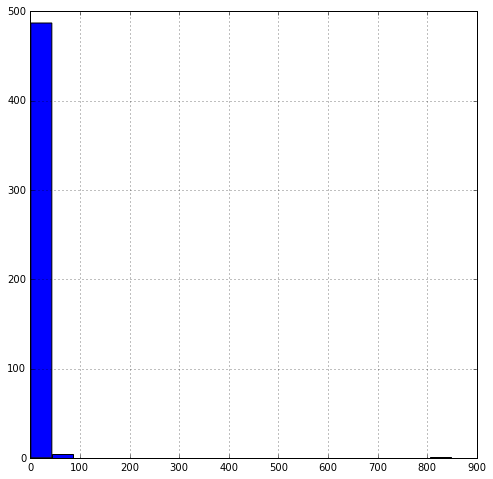

In [8]:
assays.target_chembl_id.hist(bins=20)

(123, 1)


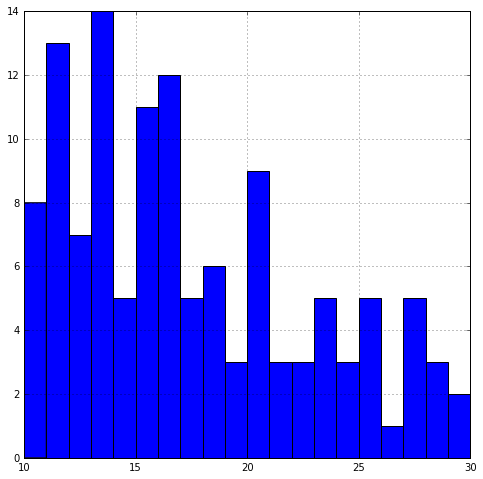

In [9]:
goodassays = assays.ix[(assays.target_chembl_id >= 10)&(assays.target_chembl_id <= 30)]
print goodassays.shape
goodassays.target_chembl_id.hist(bins=20)

In [10]:
data2 = data.ix[data.assay_chembl_id.isin(list(goodassays.index))]
data2.shape

(2091, 30)

## Now get the SMILES

In [11]:
molecule = new_client.molecule
cs = molecule.get(molecule_chembl_id=list(data2['molecule_chembl_id']))
smiles = pd.Series(map(lambda x: x['molecule_structures']['canonical_smiles'], cs), index=data2.index)
data2['SMILES'] = smiles

In [12]:
PandasTools.AddMoleculeColumnToFrame(data2, smilesCol = 'SMILES',includeFingerprints=True)

Let's start by looking at assays that have between 10 and 12 compounds:

In [13]:
assays = data2[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
goodassays = assays.ix[(assays.target_chembl_id >= 10)&(assays.target_chembl_id <= 12)]
subset = data2.ix[data.assay_chembl_id.isin(list(goodassays.index))]
print subset.shape

(123, 1)
(307, 32)


In [14]:
mols = subset[['molecule_chembl_id','SMILES', 'ROMol', 'assay_chembl_id']]
mols.shape

(307, 4)

,molecule_chembl_id,SMILES,ROMol,assay_chembl_id
51,CHEMBL28607,Oc1ccc(OCCNCc2ccccc2)cc1,,CHEMBL669161
52,CHEMBL156896,Oc1ccccc1N2CCN(Cc3ccccc3)CC2,,CHEMBL669161
53,CHEMBL156732,C(N1CCN(CC1)c2ccccc2)c3ccccc3,,CHEMBL669161
54,CHEMBL347291,Oc1ccccc1OCCNCc2ccccc2,,CHEMBL669161
55,CHEMBL2112913,CS(=O)(=O)Nc1cc(OCCNCc2cccs2)ccc1F,,CHEMBL669161

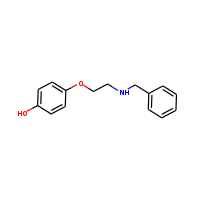
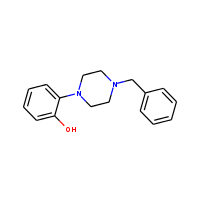
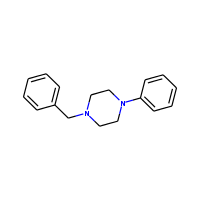
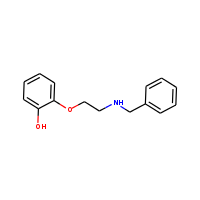
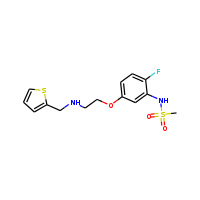

In [15]:
mols.head(5)

Construct fingerprints:

In [16]:
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols['ROMol']]

Now the distance matrix:

In [17]:
dist_mat = []
for i,fp in enumerate(fps):
    dist_mat.append(DataStructs.BulkTanimotoSimilarity(fps[i],fps,returnDistance=1))
dist_mat=numpy.array(dist_mat)

And now do the MDS into 2 dimensions:

In [18]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=3, n_jobs = 4, verbose=1,max_iter=1000)
results = mds.fit(dist_mat)
coords = results.embedding_
print 'Final stress:',mds.stress_

breaking at iteration 398 with stress 4361.02082966
breaking at iteration 422 with stress 4263.85201928
breaking at iteration 450 with stress 4380.32706244
breaking at iteration 479 with stress 4443.37044781
Final stress: 4263.85201928


And plot the points:

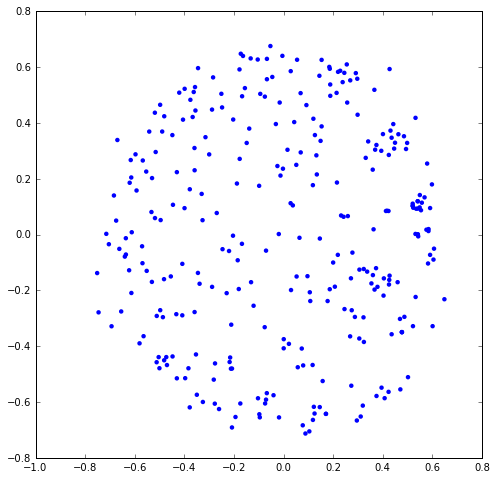

In [19]:
scatter([x for x,y in coords], [y for x,y in coords],edgecolors='none')

Nice picture. How accurate is it?

The strain values above lead me to believe that there are probably some real problems here.

The overall strain value isn't particularly easy to interpret, so we'll check up on things by comparing the embedded distances with the Tanimoto distances we're trying to reproduce.

In [20]:
import random
def distCompare(dmat,coords,nPicks=5000,seed=0xf00d):
    """ picks a random set of pairs of points to compare distances """
    nPts=len(coords)
    random.seed(seed)
    res=[]
    keep=set()
    if nPicks>0:
        while len(res)<nPicks:
            idx1 = random.randint(0,nPts-1)
            idx2 = random.randint(0,nPts-1)
            if idx1==idx2: 
                continue
            if idx1>idx2: 
                idx1,idx2=idx2,idx1
            if (idx1,idx2) in keep: 
                continue
            keep.add((idx1,idx2))
            p1 = coords[idx1]
            p2 = coords[idx2]
            v = p1-p2
            d = sqrt(v.dot(v))
            res.append((dmat[idx1][idx2],d))
    else:
        for idx1 in range(nPts):
            for idx2 in range(idx1+1,nPts):
                p1 = coords[idx1]
                p2 = coords[idx2]
                v = p1-p2
                d = sqrt(v.dot(v))
                res.append((dmat[idx1][idx2],d))
    return res

In [21]:
d = distCompare(dist_mat,coords)

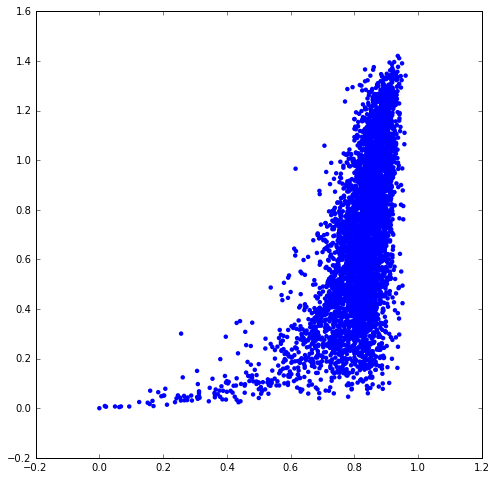

In [22]:
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Yikes... that's no good. This really isn't so surprising given how much stress was left.

Let's try increasing the dimensionality to see how much improvement we can get:

In [23]:
mds2 = manifold.MDS(n_components=20, dissimilarity="precomputed", random_state=3, n_jobs = 4, verbose=1,max_iter=1000)
results = mds2.fit(dist_mat)
coords = results.embedding_
print 'Final stress:',mds2.stress_

breaking at iteration 261 with stress 122.957903637
breaking at iteration 249 with stress 122.366087858
breaking at iteration 271 with stress 120.722555337
breaking at iteration 266 with stress 122.398041816
Final stress: 120.722555337


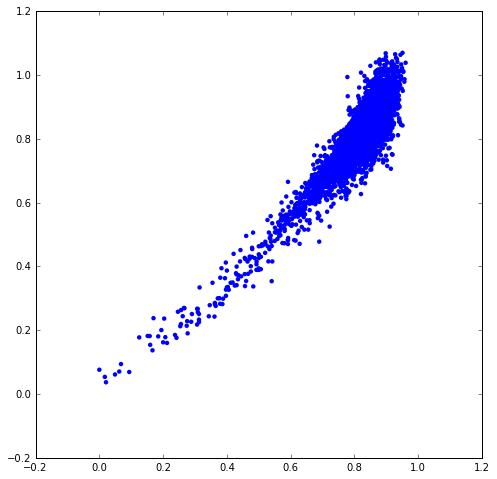

In [24]:
d = distCompare(dist_mat,coords)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Not so bad... of course, we can't visualize 20 dimensions.

What about if we try doing dimensionality reduction on the 20D results instead of using the distance matrix?

In [25]:
mds3 = manifold.MDS(n_components=2, random_state=3, n_jobs = 4, verbose=1,max_iter=1000)
results3 = mds3.fit(coords)
coords3 = results3.embedding_
print 'Final stress:',mds3.stress_

breaking at iteration 282 with stress 4263.34187798
breaking at iteration 347 with stress 4216.67532472
breaking at iteration 394 with stress 4220.50386873
breaking at iteration 371 with stress 4272.69917046
Final stress: 4216.67532472


The strain is still really high. This isn't that surprising given that we already tried the same thing from the distance matrix.

Ok, so MDS doesn't work. Now that we have actual coordinates, we can use some of the other scikit-learn manifold learning approaches for embedding the points.

Instead of jumping all the way to a 2D system, where we're really unlikely to get decent results, start by dropping down to 10D.

First MDS in 10D:

breaking at iteration 213 with stress 275.719972469
breaking at iteration 221 with stress 270.524855973
breaking at iteration 226 with stress 273.789365441
breaking at iteration 227 with stress 277.339022756
Final stress: 270.524855973


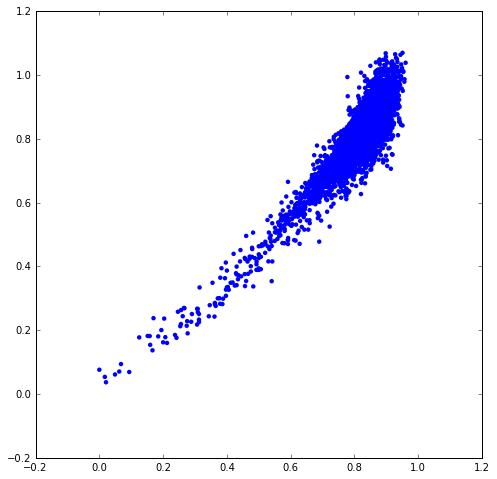

In [26]:
mds3 = manifold.MDS(n_components=10, random_state=3, n_jobs = 4, verbose=1,max_iter=1000)
results3 = mds3.fit(coords)
coords3 = results3.embedding_
print 'Final stress:',results3.stress_
ds = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Now try locally linear embedding:

-3.87201313905e-16


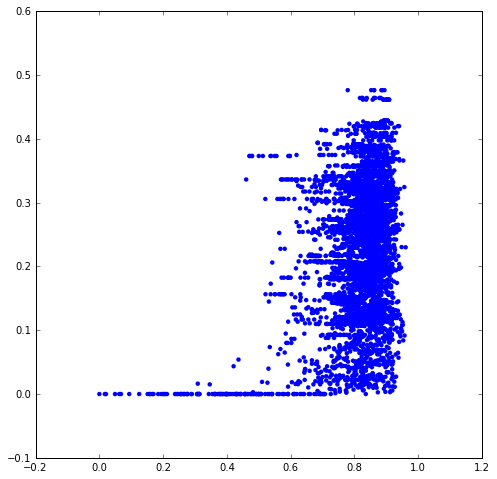

In [27]:
lle = manifold.LocallyLinearEmbedding(n_components=10,random_state=3,max_iter=1000)
results3=lle.fit(coords)
coords3=results3.embedding_
print results3.reconstruction_error_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Ick! What about Isomap?

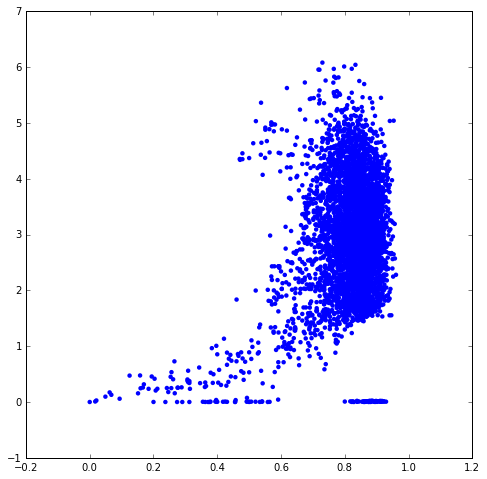

In [28]:
embed = manifold.Isomap(n_components=10,max_iter=1000)
results3=embed.fit(coords)
coords3=results3.embedding_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Also pretty grim. Does spectral embedding work?

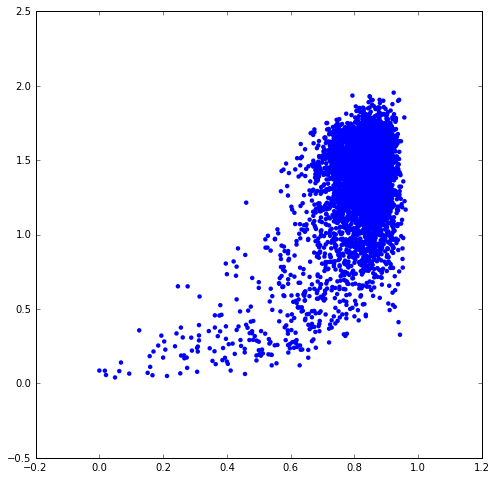

In [29]:
embed = manifold.SpectralEmbedding(n_components=10)
results3=embed.fit(coords)
coords3=results3.embedding_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Hmm, there's at least some signal there. How does spectral embedding do with 2D?

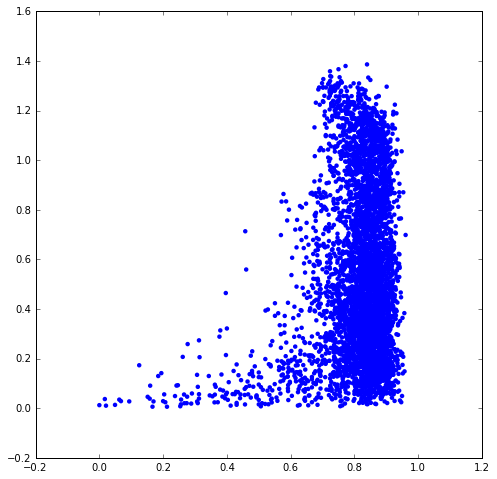

In [30]:
embed = manifold.SpectralEmbedding(n_components=2)
results3=embed.fit(coords)
coords3=results3.embedding_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

Not so hot...

## Look at stress vs dimension

We're able to do a reasonable job of embedding into 20 dimensions with MDS. 10 even looks somewhat ok. Let's look at behavior of the residual stress as a function of dimension:

Final stress at dim=140: 14.8882703507 stress per element: 0.0484959946277
Final stress at dim=120: 15.6363159571 stress per element: 0.0509326252676
Final stress at dim=100: 17.1525426952 stress per element: 0.0558714745771
Final stress at dim=80: 19.4234713492 stress per element: 0.0632686363166
Final stress at dim=60: 24.673693386 stress per element: 0.0803703367621
Final stress at dim=40: 39.8924727179 stress per element: 0.129942907876
Final stress at dim=20: 120.722555337 stress per element: 0.393233079273
Final stress at dim=10: 383.132794574 stress per element: 1.24798955887
Final stress at dim=5: 1115.25419255 stress per element: 3.63274981287
Final stress at dim=2: 4263.85201928 stress per element: 13.8887687924


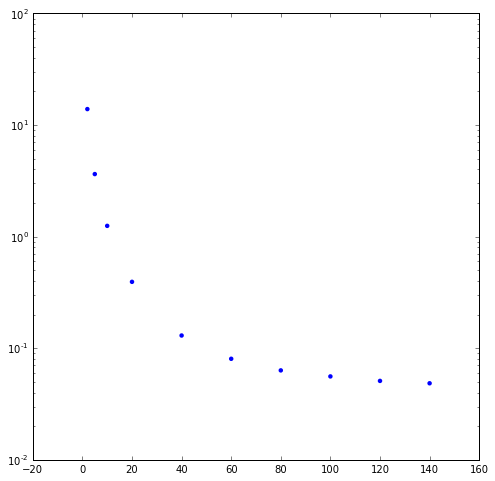

In [31]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(n_components=nComps, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

Yeah, the stress is going up exponentially with dimension. These data really don't want to be in a 2D space.

Try non-metric embedding

Final stress at dim=140: 21.0074470128 stress per element: 0.0684281661654
Final stress at dim=120: 24.8462805787 stress per element: 0.0809325100283
Final stress at dim=100: 29.0718704363 stress per element: 0.0946966463724
Final stress at dim=80: 36.5797807548 stress per element: 0.119152380309
Final stress at dim=60: 48.1876811144 stress per element: 0.156963130666
Final stress at dim=40: 72.5718624184 stress per element: 0.23639043133
Final stress at dim=20: 154.832521219 stress per element: 0.504340459997
Final stress at dim=10: 329.900416347 stress per element: 1.07459419006
Final stress at dim=5: 749.165314679 stress per element: 2.44027789798
Final stress at dim=2: 2116.52559942 stress per element: 6.89422019356


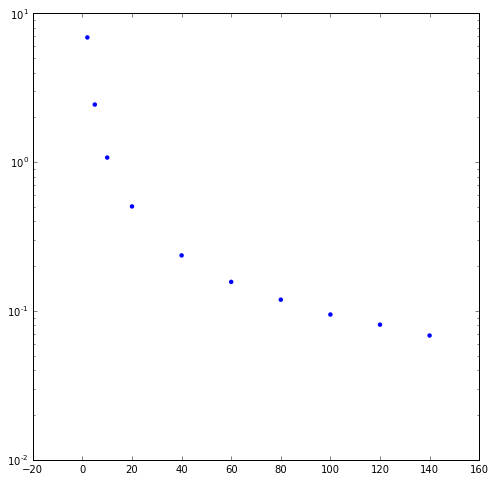

In [32]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(metric=False,n_components=nComps,random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

helps somewhat at lower dimension, but not dramatically. Plus it's a lot slower

## A larger data set

Maybe it's possible to do better with a larger data set? This seems unlikely, but we can at least try:

In [33]:
assays = data2[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
goodassays = assays.ix[(assays.target_chembl_id >= 10)&(assays.target_chembl_id <= 15)]
subset = data2.ix[data.assay_chembl_id.isin(list(goodassays.index))]
print subset.shape

(123, 1)
(724, 32)


In [34]:
mols = subset[['molecule_chembl_id','SMILES', 'ROMol', 'assay_chembl_id']]
print mols.shape
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols['ROMol']]
dist_mat = []
for i,fp in enumerate(fps):
    dist_mat.append(DataStructs.BulkTanimotoSimilarity(fps[i],fps,returnDistance=1))
dist_mat=numpy.array(dist_mat)    
print dist_mat.shape 

(724, 4)
(724, 724)


Final stress at dim=140: 78.2088255907 stress per element: 0.108023239766
Final stress at dim=120: 83.6551686632 stress per element: 0.115545813071
Final stress at dim=100: 93.1013936693 stress per element: 0.128593085179
Final stress at dim=80: 111.281591781 stress per element: 0.153703856051
Final stress at dim=60: 147.131195236 stress per element: 0.203219882923
Final stress at dim=40: 253.492878306 stress per element: 0.350128284953
Final stress at dim=20: 798.544457868 stress per element: 1.10296195838
Final stress at dim=10: 2432.03911801 stress per element: 3.3591700525
Final stress at dim=5: 6874.90956116 stress per element: 9.49573143807
Final stress at dim=2: 25597.5135218 stress per element: 35.3556816599


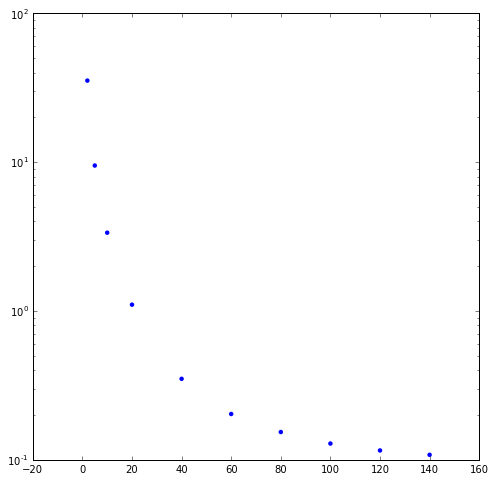

In [35]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(n_components=nComps, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

Nope, that definitely made things worse.

## and larger still

In [36]:
assays = data2[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
goodassays = assays.ix[(assays.target_chembl_id >= 10)&(assays.target_chembl_id <= 18)]
subset = data2.ix[data.assay_chembl_id.isin(list(goodassays.index))]
print subset.shape

(123, 1)
(1109, 32)


In [37]:
mols = subset[['molecule_chembl_id', 'SMILES', 'ROMol', 'assay_chembl_id']]
print mols.shape
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols['ROMol']]
dist_mat = []
for i,fp in enumerate(fps):
    dist_mat.append(DataStructs.BulkTanimotoSimilarity(fps[i],fps,returnDistance=1))
dist_mat=numpy.array(dist_mat)    
print dist_mat.shape

(1109, 4)
(1109, 1109)


Final stress at dim=140: 168.176814082 stress per element: 0.151647262472
Final stress at dim=120: 182.160599986 stress per element: 0.16425662758
Final stress at dim=100: 204.40034102 stress per element: 0.184310496862
Final stress at dim=80: 247.402896742 stress per element: 0.223086471364
Final stress at dim=60: 332.760745419 stress per element: 0.30005477495
Final stress at dim=40: 597.306401455 stress per element: 0.538599099599
Final stress at dim=20: 1941.54192483 stress per element: 1.75071408912
Final stress at dim=10: 5902.784547 stress per element: 5.32261906853
Final stress at dim=5: 16541.3567152 stress per element: 14.9155606089
Final stress at dim=2: 60946.5239554 stress per element: 54.9562885081


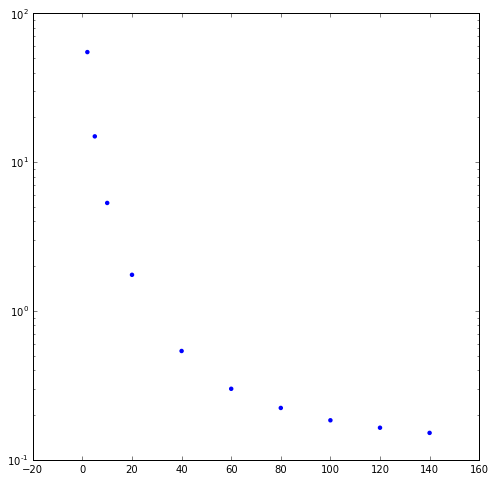

In [38]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(n_components=nComps, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

Continuing to get worse.

## Try less data

In [39]:
assays = data2[['assay_chembl_id','target_chembl_id']].groupby('assay_chembl_id').count()
print assays.shape
goodassays = assays.ix[assays.target_chembl_id == 15]
subset = data2.ix[data.assay_chembl_id.isin(list(goodassays.index))]
print subset.shape

(123, 1)
(165, 32)


In [40]:
mols = subset[['molecule_chembl_id','SMILES', 'ROMol', 'assay_chembl_id']]
print mols.shape
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols['ROMol']]
dist_mat = []
for i,fp in enumerate(fps):
    dist_mat.append(DataStructs.BulkTanimotoSimilarity(fps[i],fps,returnDistance=1))
dist_mat=numpy.array(dist_mat)    
print dist_mat.shape

(165, 4)
(165, 165)


Final stress at dim=140: 5.02067116244 stress per element: 0.0304283100754
Final stress at dim=120: 5.31739457656 stress per element: 0.0322266337973
Final stress at dim=100: 5.6302199229 stress per element: 0.0341225449873
Final stress at dim=80: 6.11308024789 stress per element: 0.0370489711993
Final stress at dim=60: 7.31432679352 stress per element: 0.0443292532941
Final stress at dim=40: 11.3054367059 stress per element: 0.0685177982175
Final stress at dim=20: 30.2462507814 stress per element: 0.183310610796
Final stress at dim=10: 98.8025008019 stress per element: 0.598803035163
Final stress at dim=5: 300.305403639 stress per element: 1.82003274933
Final stress at dim=2: 1230.25783895 stress per element: 7.45610811484


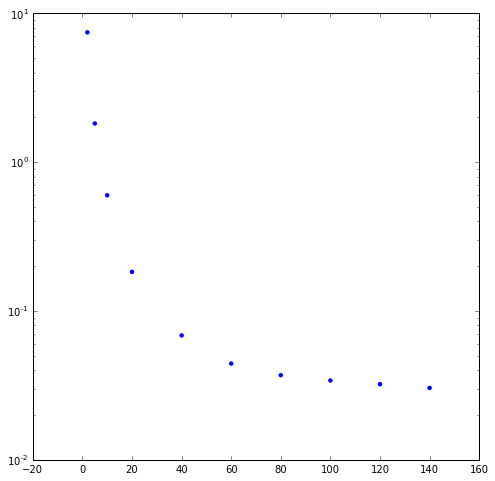

In [41]:
vs={}
for nComps in (140,120,100,80,60,40,20,10,5,2):
    mds3 = manifold.MDS(n_components=nComps, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
    results3 = mds3.fit(dist_mat)
    print 'Final stress at dim=%d:'%nComps,results3.stress_,'stress per element:',results3.stress_/len(dist_mat)
    vs[nComps]=results3.stress_/len(dist_mat)
scatter(vs.keys(),vs.values(),edgecolors='none')
yscale('log')

That's a lot less stress per point than before, but it's still pretty high. Look at the distances to be sure:

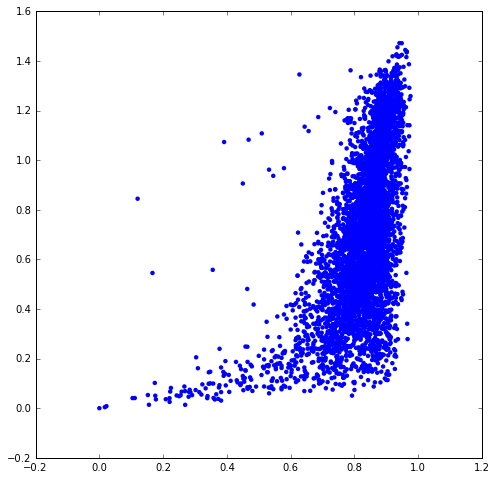

In [42]:
mds3 = manifold.MDS(n_components=2, random_state=3, dissimilarity="precomputed",n_jobs = 4, verbose=0,max_iter=1000)
results3 = mds3.fit(dist_mat)
coords3=results3.embedding_
d = distCompare(dist_mat,coords3)
scatter([x for x,y in d],[y for x,y in d],edgecolors='none')